### Import package

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import sqlite3
import json
from datetime import datetime

from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error

### Read Bouy Station Information

In [2]:
with open('../buoy_station_name.json','r') as outfile:
    stndata=json.load(outfile)

data=[]
for ids in stndata:
    info = stndata[ids]
    data.append([ids,info['STN'],info['LAT'],info['LON'],info['LOCATE'],info['OWNER']])
    
# set up column names
columns = ['ST', 'STN','LAT','LON','LOCATE','OWNER']

# list to DataFrame 
stdf = pd.DataFrame(data=data,columns=columns)
stdf

,ST,STN,LAT,LON,LOCATE,OWNER
0,4N11,將軍,null,null,臺南將軍安檢所樓頂,氣象局
1,46694A,龍洞浮標,25.097778,121.9225,東北角龍洞遊艇港外海約0.25公里，該處水深約27公尺。,中央氣象局
2,46699A,花蓮浮標,24.031944,121.631389,花蓮七星潭外海約1公里，該處水深約30公尺。,中央氣象局
3,46708A,龜山島浮標,24.846667,121.926111,宜蘭龜山島龜尾端西方1公里，該處水深約25公尺。,交通部觀光局
4,46714D,小琉球浮標,22.313611,120.362778,小琉球海子口西南方外海約1.2公里，該處水深約99公尺。,中央氣象局
...,...,...,...,...,...,...
97,1306,臺北港,25.156667,121.371667,臺北港第3港埠,氣象局
98,1821,福隆,25.021667,121.95,福隆漁港碼頭,氣象局
99,1315,彭佳嶼,25.625278,122.075556,彭佳嶼海水淡化廠附近,氣象局
100,1551,和平港,24.297778,121.753889,花蓮和平港防波堤,和平工業港公司


### Read Bouy-Satellite Data Base

In [34]:
def read_sql(filename):
    conn = sqlite3.connect(filename, timeout=10)
    df = pd.read_sql("SELECT * FROM status",con=conn)
    conn.close()
    return df

filename = '../buoy_data.sqlite.p8.db'
df = read_sql(filename)

# modify dataframe
df['DATETIME'] = pd.to_datetime(df['DATETIME'])

df['H']        = df['H'].astype('float')/100.
df['T']        = df['T'].astype('float')
df['Tmean']    = df['Tmean'].astype('float')

df['Temp']     = df['Temp'].astype('float')
df['Zt']       = df['Zt'].astype('float')

df['Vm']       = df['Vm'].astype('float')
df['Dm']       = df['Dm'].astype('float')
df['Vg']       = df['Vg'].astype('float')
df['Vms']      = df['Vms'].astype('float')
df['Vgs']      = df['Vgs'].astype('float')
df['Zv']       = df['Zv'].astype('float')

df['P']        = df['P'].astype('float')

df['Vmsat']    = df['Vmsat'].astype('float')

# add STN station name variable 
def label_stname (row):
    if row['ST'] in stndata:
        return stndata[row['ST']]['STN']
    
df['STN'] = df.apply (lambda row: label_stname(row), axis=1)

df

,ST,DATETIME,H,Hs,T,Tmean,D,P,Temp,Zt,...,Dm,Vg,Vms,Vgs,Zv,QC,Hsat,Tsat,Vmsat,STN
0,46694A,2010-01-01 00:00:00,1.50,S,87.0,63.0,56,1021.9,18.1,0.0,...,65.0,6.6,3.0,4.0,3.0,Q,None,None,NaN,龍洞浮標
1,46694A,2010-01-01 01:00:00,1.83,M,95.0,64.0,90,1021.8,18.1,0.0,...,69.0,6.4,3.0,4.0,3.0,Q,None,None,NaN,龍洞浮標
2,46694A,2010-01-01 02:00:00,2.07,M,80.0,64.0,67,1021.0,18.1,0.0,...,78.0,7.0,3.0,4.0,3.0,Q,None,None,NaN,龍洞浮標
3,46694A,2010-01-01 03:00:00,2.13,M,95.0,66.0,67,1020.5,18.0,0.0,...,64.0,7.5,3.0,4.0,3.0,Q,None,None,NaN,龍洞浮標
4,46694A,2010-01-01 04:00:00,2.32,M,87.0,67.0,56,1019.9,18.2,0.0,...,67.0,7.2,3.0,4.0,3.0,Q,None,None,NaN,龍洞浮標
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896809,C0U75,2016-01-01 02:00:00,NaN,None,NaN,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,None,None,None,7.847967,龜山島
1896810,1306,2016-01-01 02:00:00,NaN,None,NaN,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,None,None,None,10.722089,臺北港
1896811,1821,2016-01-01 02:00:00,NaN,None,NaN,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,None,None,None,9.172004,福隆
1896812,1315,2016-01-01 02:00:00,NaN,None,NaN,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,None,None,None,11.670791,彭佳嶼


### Get "dataset"

In [32]:
dataset = df[['STN','ST','DATETIME','H','Temp','P','Vm','Vmsat']]
dataset = dataset.dropna()

### Plot Averaged Wind Speed

<Figure size 3200x1600 with 0 Axes>

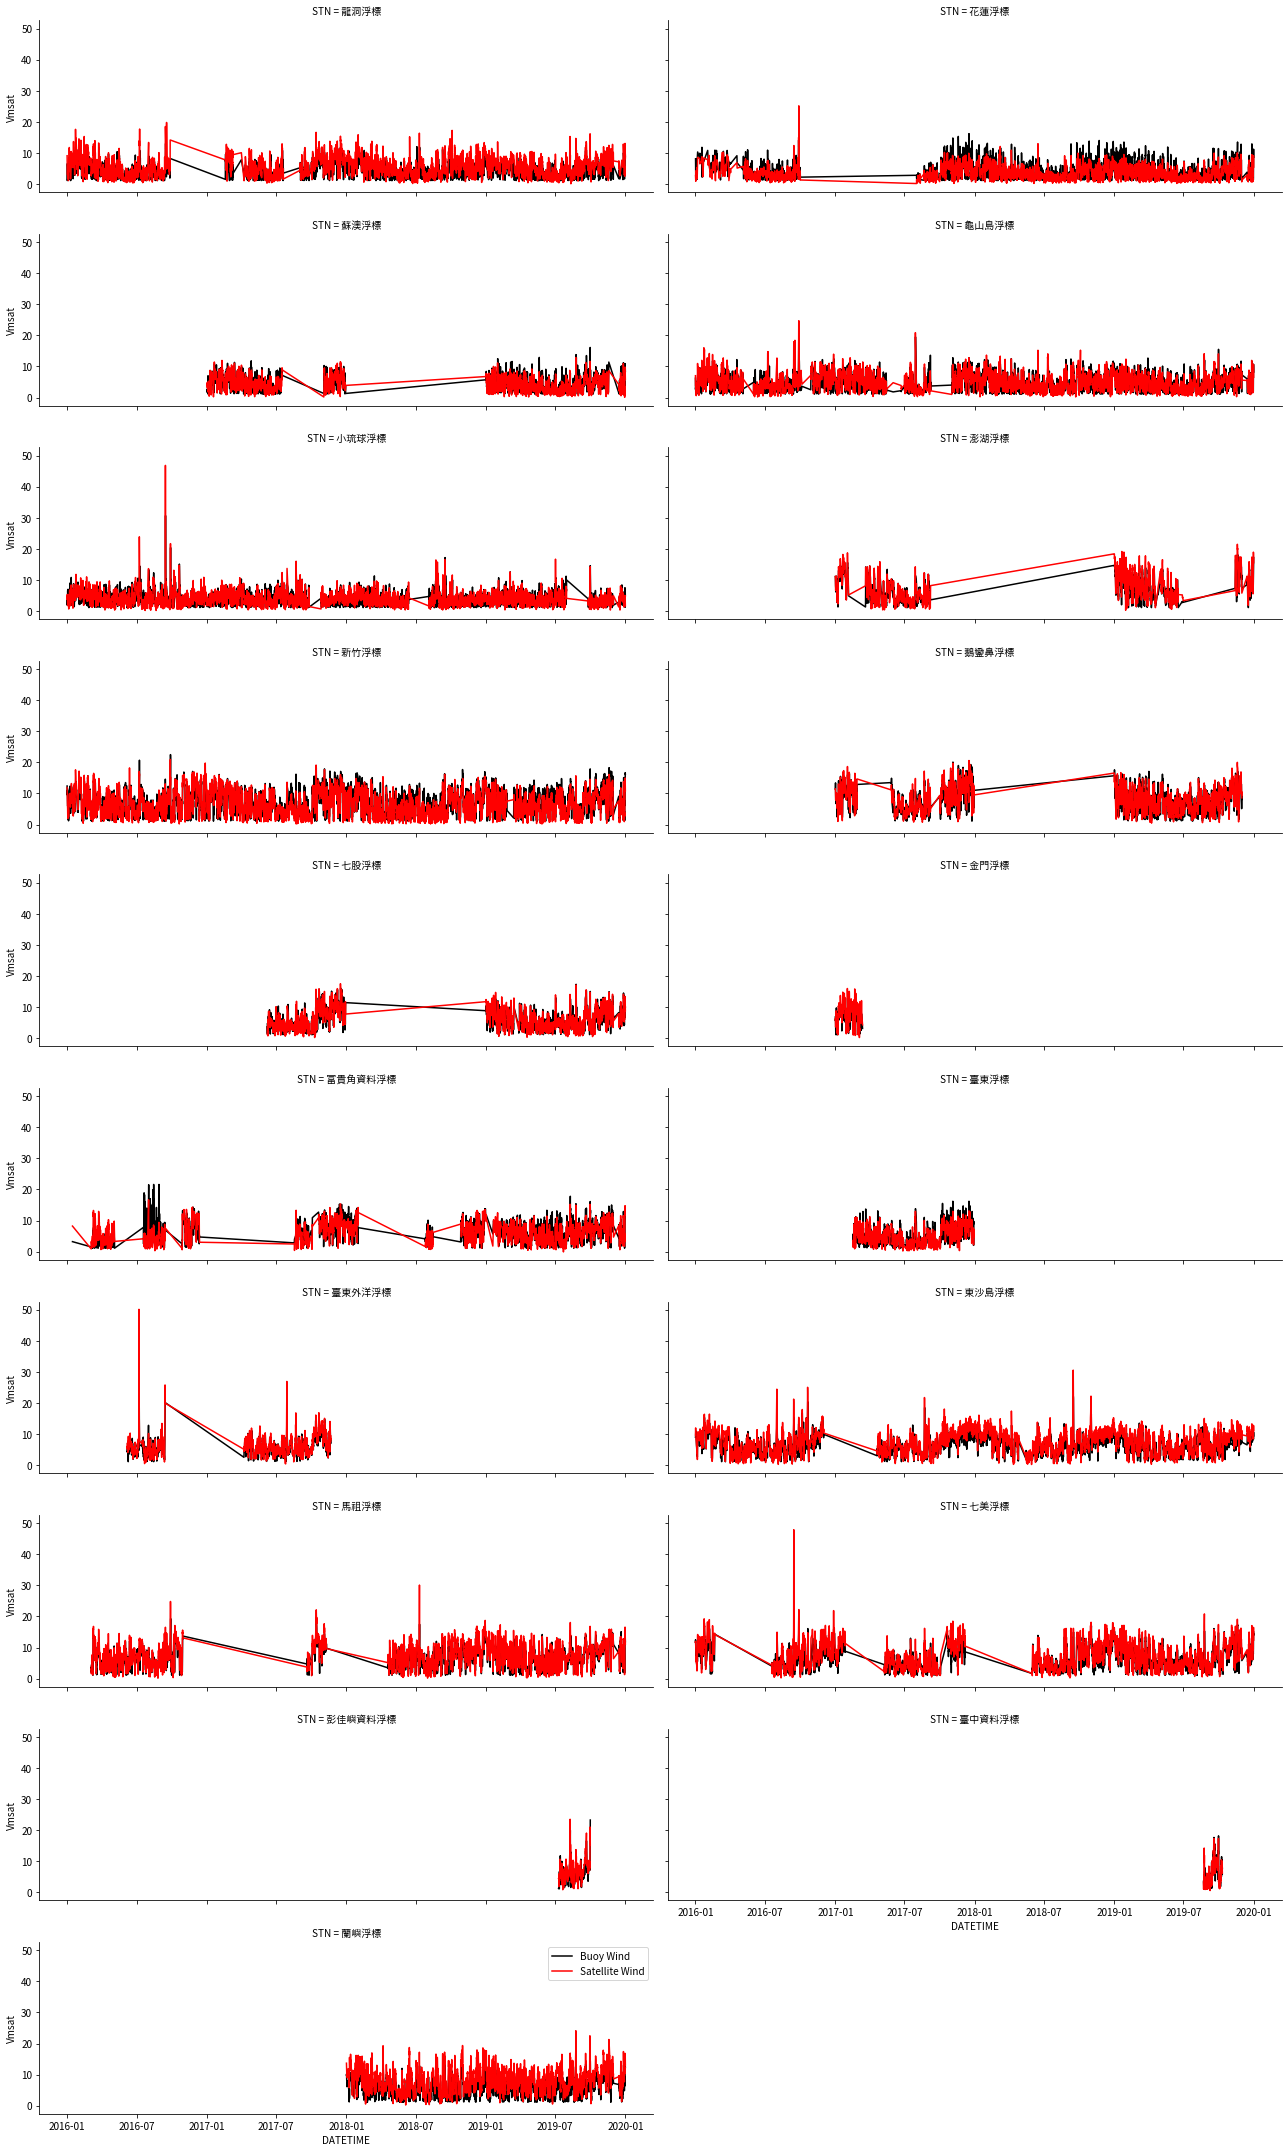

In [33]:
def plot_Vm(data):
    %matplotlib inline
    plt.figure(figsize=(16,8),dpi=200)
    g = sns.FacetGrid(data, col="STN", col_wrap=2, height=3, aspect=3)
    g.map(sns.lineplot, 'DATETIME','Vm',color='k')
    g.map(sns.lineplot, 'DATETIME','Vmsat',color='r')
    plt.legend(labels=['Buoy Wind','Satellite Wind'])
    
plot_Vm(dataset)

### Spearman Correlation Coefficient

In [8]:
def corr_coef(x,y):
    correlation, p = spearmanr(x, y)
    print('Correlation:', correlation)
    print('p-value:', p)
    if p >= 0.05:
        print('H0 is accepted')
    else:
        print('H0 is rejected')   

In [9]:
def corr_Vm(datain,all=True):
    if not all:
        for stn in stdf['STN']:
            data = datain[datain['STN'].isin([stn])]
            data = data.dropna()
            if not data.empty:
                x = data['Vmsat']
                y = data['Vm']
                print('-------------')
                print('std : ',stn)     
                corr_coef(x,y)
    else:
        data = datain.dropna()
        if not data.empty:
            x = data['Vmsat']
            y = data['Vm'] 
            corr_coef(x,y)  
            
corr_Vm(dataset,all=False)

-------------
std :  龍洞浮標
Correlation: 0.6196267012234807
p-value: 0.0
H0 is rejected
-------------
std :  花蓮浮標
Correlation: 0.41065889669733785
p-value: 8.245459190116942e-150
H0 is rejected
-------------
std :  龜山島浮標
Correlation: 0.5862732067342116
p-value: 0.0
H0 is rejected
-------------
std :  小琉球浮標
Correlation: 0.26240367396737896
p-value: 4.608653849182337e-72
H0 is rejected
-------------
std :  新竹浮標
Correlation: 0.730526075616901
p-value: 0.0
H0 is rejected
-------------
std :  臺東外洋浮標
Correlation: 0.8062205651773555
p-value: 1.8876185842537747e-261
H0 is rejected
-------------
std :  東沙島浮標
Correlation: 0.8350075098905538
p-value: 0.0
H0 is rejected
-------------
std :  馬祖浮標
Correlation: 0.7728800728192483
p-value: 0.0
H0 is rejected
-------------
std :  蘇澳浮標
Correlation: 0.5323503545705033
p-value: 4.706151300970012e-151
H0 is rejected
-------------
std :  澎湖浮標
Correlation: 0.8536661705155645
p-value: 0.0
H0 is rejected
-------------
std :  鵝鑾鼻浮標
Correlation: 0.7714997668035789

All buoy

In [10]:
corr_Vm(dataset,all=True)

Correlation: 0.7134554311022969
p-value: 0.0
H0 is rejected


#### RMSE

In [11]:
def rmse_Vm(datain,all=True):
    if not all:
        for stn in stdf['STN']:
            data = datain[datain['STN'].isin([stn])]
            data = data.dropna()
            if not data.empty:
                x = data['Vmsat']
                y = data['Vm']
                print('-------------')
                print('std : ',stn)     
                print('rms : ',mean_squared_error(y, x, squared=False))
    else:
        data = datain.dropna()
        if not data.empty:
            x = data['Vmsat']
            y = data['Vm'] 
            print('total rms : ',mean_squared_error(y, x, squared=False))

rmse_Vm(dataset,all=False)

-------------
std :  龍洞浮標
rms :  2.7962541847218962
-------------
std :  花蓮浮標
rms :  2.413492485209159
-------------
std :  龜山島浮標
rms :  2.4308635594689276
-------------
std :  小琉球浮標
rms :  2.4633133936182823
-------------
std :  新竹浮標
rms :  2.784597690340508
-------------
std :  臺東外洋浮標
rms :  2.3139576487047653
-------------
std :  東沙島浮標
rms :  2.132233307234441
-------------
std :  馬祖浮標
rms :  2.5274437171041497
-------------
std :  蘇澳浮標
rms :  2.289083841249888
-------------
std :  澎湖浮標
rms :  2.357161301331628
-------------
std :  鵝鑾鼻浮標
rms :  2.5281417759097
-------------
std :  七股浮標
rms :  2.4087454453786985
-------------
std :  金門浮標
rms :  2.8102550657230694
-------------
std :  富貴角資料浮標
rms :  2.9138282180299435
-------------
std :  臺東浮標
rms :  2.3922160745272483
-------------
std :  蘭嶼浮標
rms :  3.4283045196433335
-------------
std :  七美浮標
rms :  2.4716879044639133
-------------
std :  彭佳嶼資料浮標
rms :  2.8891435476459493
-------------
std :  臺中資料浮標
rms :  2.8634985011031096


Total

In [12]:
rmse_Vm(dataset,all=True)

total rms :  2.5752904306788955


### Data Quality Control

remove outliner

In [26]:
df_index = (dataset['DATETIME']>datetime(2019,1,1,0)) & (dataset['DATETIME']<datetime(2019,2,1,0))
dataqc = dataset[df_index]


In [27]:
dataqc

,STN,ST,DATETIME,H,Temp,P,Vm,Vmsat
666843,龍洞浮標,46694A,2019-01-01 06:00:00,2.37,20.4,1028.0,8.8,9.573472
666849,龍洞浮標,46694A,2019-01-01 12:00:00,2.65,21.1,1027.9,6.3,10.442423
666855,龍洞浮標,46694A,2019-01-01 18:00:00,2.15,19.9,1027.7,8.7,10.010353
666861,龍洞浮標,46694A,2019-01-02 00:00:00,2.85,20.7,1028.4,7.8,9.944195
666867,龍洞浮標,46694A,2019-01-02 06:00:00,2.19,20.0,1027.1,7.8,7.641941
...,...,...,...,...,...,...,...,...
781784,七美浮標,C6W10,2019-01-30 18:00:00,0.80,26.7,1018.5,3.6,1.752630
781790,七美浮標,C6W10,2019-01-31 00:00:00,0.92,26.5,1018.0,1.4,4.787558
781796,七美浮標,C6W10,2019-01-31 06:00:00,0.76,26.5,1017.2,1.6,4.723269
781802,七美浮標,C6W10,2019-01-31 12:00:00,0.81,26.7,1018.8,2.5,6.263445


<Figure size 3200x1600 with 0 Axes>

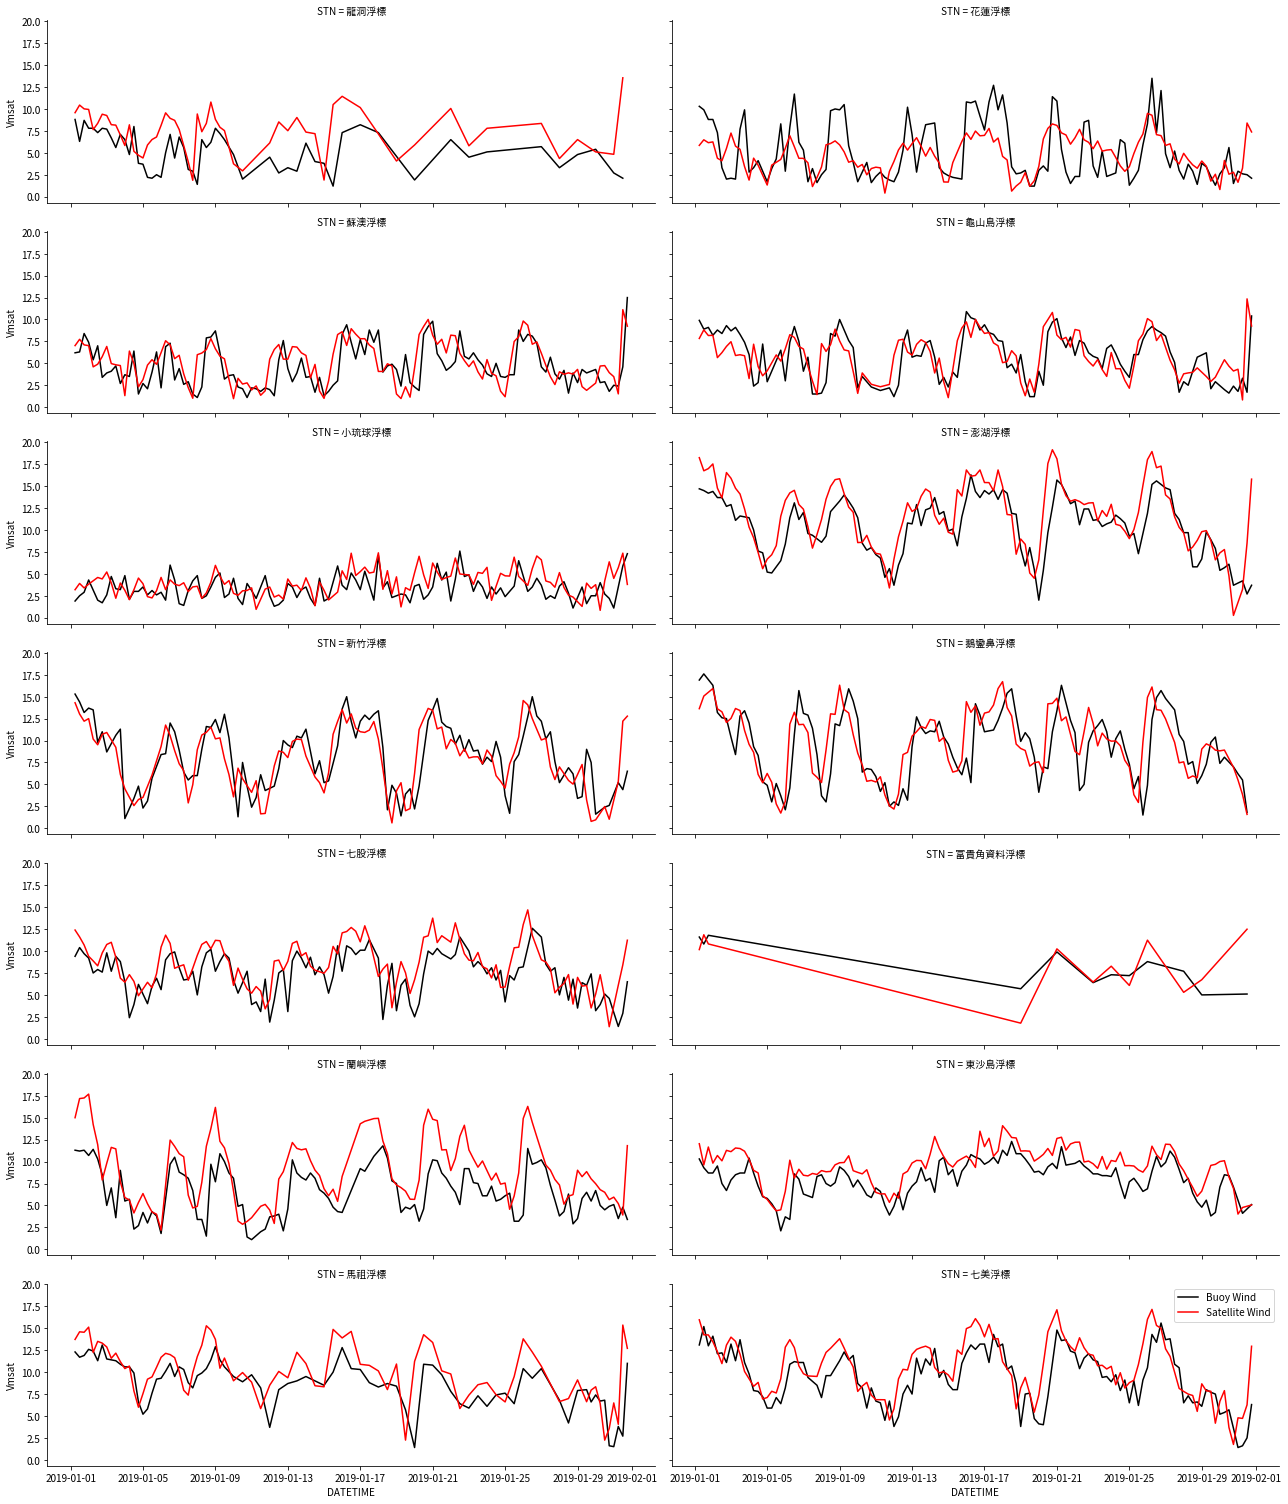

In [28]:
plot_Vm(dataqc)

In [29]:
corr_Vm(dataqc)

Correlation: 0.7686299810680859
p-value: 9.094049442369862e-286
H0 is rejected


In [30]:
rmse_Vm(dataqc)

total rms :  2.6593649783333135
